In [2]:
import lightning as pl
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from ultralytics import YOLO
from datasets import load_dataset
from torch.utils.data import DataLoader

## Dataset

In [3]:
def load_data():
    dataset = load_dataset("bastienp/visible-watermark-pita")
    return dataset

In [4]:
hugging_dataset = load_data()

Generating train split: 98 examples [00:00, 732.05 examples/s]
Generating test split: 30 examples [00:00, 9554.22 examples/s]
Generating val split: 18 examples [00:00, 7311.40 examples/s]


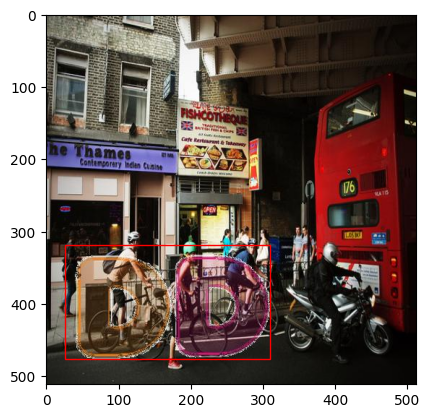

In [5]:
import matplotlib.pyplot as plt

sample = hugging_dataset['train'][1]
bbox = sample['bbox']
# plot the first image in the dataset with the bbox on it
plt.imshow(sample['image'])
plt.gca().add_patch(plt.Rectangle((bbox[0] - bbox[2] // 2, bbox[1] - bbox[3] // 2), bbox[2], bbox[3], fill=False, edgecolor='r', linewidth=1))
plt.show()

In [6]:
dataloader = DataLoader(hugging_dataset, shuffle=True, batch_size=16)

## Training with Ultralytics

In [5]:
import os
from tqdm import tqdm


def annotate(data, data_dir, split="train"):
    data = data[split]

    image_dir = f'{data_dir}/images'
    label_dir = f'{data_dir}/labels'
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for d in data:
        print(d)
        img_id = d['image_id']
        zfilled = str(img_id).zfill(12)
        image_path = f'{image_dir}/{zfilled}.png'
        label_path = f'{label_dir}/{zfilled}.txt'
        image = d['image']
        image.save(image_path)
        
        boxes = d['bbox']
        # normalize the boxes
        boxes = [b / image.size[0] for b in boxes]
        category = d['category_id'] - 1

        label = str(category) + ' ' + ' '.join(list(map(str, boxes)))
        print(label)
        with open(label_path, 'w') as f:
            f.write(label)

In [6]:
data = load_data()
annotate(data, 'data/train')

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x290A75050>, 'bbox': [271, 131, 482, 69], 'id': 7, 'area': 33258, 'image_id': 782, 'category_id': 2}
1 0.529296875 0.255859375 0.94140625 0.134765625
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x290E73210>, 'bbox': [347, 90, 278, 131], 'id': 4, 'area': 36418, 'image_id': 34156, 'category_id': 1}
0 0.677734375 0.17578125 0.54296875 0.255859375
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x290E72E90>, 'bbox': [166, 458, 283, 53], 'id': 2, 'area': 14999, 'image_id': 127929, 'category_id': 1}
0 0.32421875 0.89453125 0.552734375 0.103515625
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x290E71D10>, 'bbox': [102, 475, 155, 22], 'id': 6, 'area': 3410, 'image_id': 204136, 'category_id': 1}
0 0.19921875 0.927734375 0.302734375 0.04296875
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x290E71B50>

In [14]:
import yaml


config = {
    'path': './data',
    'train': 'train/images',
    'val': 'valid/images',
    'names': {0: "logo", 1: "text"},
    'nc': 2
}

with open('data/data.yaml', 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

In [7]:
DATA_PATH = "output_dataset"

In [9]:
yolo = YOLO('yolov8n.pt')
results = yolo.train(data=f'{DATA_PATH}/metadata.yml', epochs=10, imgsz=512)

Ultralytics YOLOv8.1.8 🚀 Python-3.11.6 torch-2.1.2 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=../../pita_tool/output_dataset/metadata.yml, epochs=10, time=None, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

RuntimeError: Dataset '../../pita_tool/output_dataset/metadata.yml' error ❌ could not determine a constructor for the tag 'tag:yaml.org,2002:python/object:pita_dataset.yolo_annotations.YOLOConfig'
  in "<unicode string>", line 1, column 1:
    !!python/object:pita_dataset.yol ... 
    ^